In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

import utils_data

In [2]:
# Choose dataset to use
# For the MNIST dataset, we use the default torchvision data loader
# For YaleB Face dataset, download the data .zip and put it in the ./data folder.

DATASET = 'MNIST'
# DATASET = 'YALEB'

X_all, y_all = utils_data.load_dataset(name=DATASET, root='./data')

Number of samples: 5949


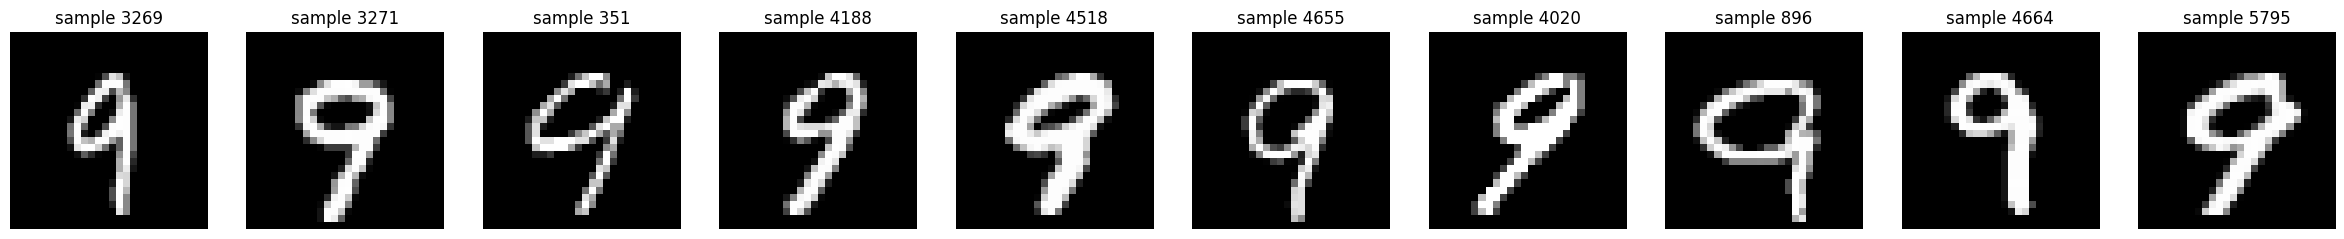

In [3]:
def filter_classes_or_individuals(classes):
    samples = []
    for c in classes:
        samples.append(X_all[y_all==c])
    return torch.vstack(samples)


## Filter out classes or individuals
## MNIST: Class 0 - 9
## YALEB: Class 1 - 38
CLASSES = [9] # MODIFY THIS LINE
X = filter_classes_or_individuals(CLASSES)


# Visualize Samples
print(f'Number of samples: {X.shape[0]}')
sample_idxs = np.random.choice(X.shape[0], 10, replace=False)
fig, ax = plt.subplots(ncols=10, figsize=(30, 5))
for i, sample_idx in enumerate(sample_idxs):
    ax[i].imshow(X[sample_idx].reshape(28, 28), cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(f'sample {sample_idx}')
plt.show()

## Part (a)
Implement the `sample_mean` and `sample_covariance` function to compute the sample mean and sample covariance.

torch.Size([784]) torch.Size([784, 784])


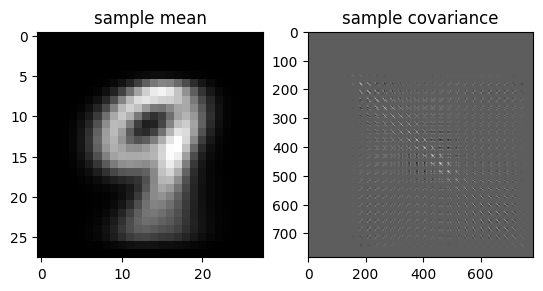

In [4]:
# compute sample mean and covariance
n_samples, data_dim = X.shape
sample_mean = torch.mean(X, 0)
sample_covariance = ((X - sample_mean).T @ (X - sample_mean)) / (X.size(0) - 1)
print(sample_mean.shape, sample_covariance.shape)


# plot sample mean and variance
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(sample_mean.view(28, 28).numpy(), cmap='gray')
ax[0].set_title('sample mean')
ax[1].imshow(sample_covariance.numpy(), cmap='gray')
ax[1].set_title('sample covariance')
plt.show()

## Part (b)
 Suppose we optimize the maximum log-likelihood for our pPCA problem to find the optimal parameters for `W`. Implement what the estimate for `W` should be (i.e., `W_estimate`)

In [5]:
# based on solution to maximum likelihood, compute optimal W
latent_dim = 10
U, S, _ = torch.svd(sample_covariance)
U1, S1, sigma2 = U[:, :latent_dim], S[:latent_dim], torch.mean(S[latent_dim:])
W_estimate = U1 @ torch.diag(torch.sqrt(S1 - sigma2))

## Part (c)
For the final step, we finish off by implementing the latent distribution and noise distribution. What are they? Fill in your answer for variables `z` and `eps`. 

/var/folders/7s/hpf056xj6tx66gwy6sk88pxm0000gn/T/ipykernel_12478/4290751360.py:9: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3679.)
  X_sampled_j = sample_mean.T + W_estimate @ z + eps


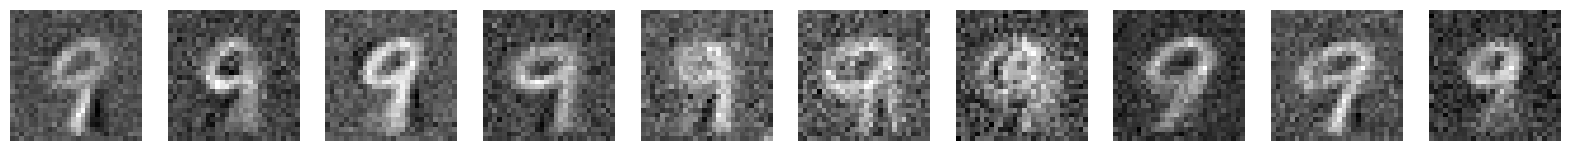

In [6]:
# sample and generate from latent space
X_sampled = []
N_SAMPLES = 10
for j in range(N_SAMPLES):
    z = torch.randn(latent_dim)
    eps = torch.randn(784) * torch.sqrt(sigma2)
    
    # generate sample for X
    X_sampled_j = sample_mean.T + W_estimate @ z + eps
    X_sampled.append(X_sampled_j.view(28, 28))
    

# visualize sampled X
fig, ax = plt.subplots(ncols=10, figsize=(20, 3))
for j in range(N_SAMPLES):
    ax[j].imshow(X_sampled[j], cmap='gray')
    ax[j].axis('off')
plt.show()

In [8]:
# PPCA MODEL
def ppca(CLASSES, latent_dim, var_mul):
    print(f"Running PPCA model with {len(CLASSES)} class: {CLASSES} and latent dimension {latent_dim}")
    
    ## Filter out classes or individuals
    X = filter_classes_or_individuals(CLASSES)

    # Visualize Samples
    sample_idxs = np.random.choice(X.shape[0], 10, replace=False)
    fig, ax = plt.subplots(ncols=10, figsize=(30, 5))
    for i, sample_idx in enumerate(sample_idxs):
        ax[i].imshow(X[sample_idx].reshape(28, 28), cmap='gray')
        ax[i].axis('off')
        ax[i].set_title(f'sample {sample_idx}')
    plt.show()

    # compute sample mean and covariance
    n_samples, data_dim = X.shape
    sample_mean = torch.mean(X, 0)
    sample_covariance = ((X - sample_mean).T @ (X - sample_mean)) / (X.size(0) - 1)
    
    # plot sample mean and variance
    fig, ax = plt.subplots(ncols=2)
    ax[0].imshow(sample_mean.view(28, 28).numpy(), cmap='gray')
    ax[0].set_title('sample mean')
    ax[1].imshow(sample_covariance.numpy(), cmap='gray')
    ax[1].set_title('sample covariance')
    plt.show()

    # based on solution to maximum likelihood, compute optimal W
    U, S, _ = torch.svd(sample_covariance)
    U1, S1, sigma2 = U[:, :latent_dim], S[:latent_dim], torch.mean(S[latent_dim:])
    W_estimate = U1 @ torch.diag(torch.sqrt(S1 - sigma2))

    # sample and generate from latent space
    X_sampled = []
    N_SAMPLES = 10
    for j in range(N_SAMPLES):
        z = torch.randn(latent_dim)
        eps = torch.randn(784) * torch.sqrt(sigma2) * var_mul
        
        # generate sample for X
        X_sampled_j = sample_mean.T + W_estimate @ z + eps
        X_sampled.append(X_sampled_j.view(28, 28))
    
    # visualize sampled X
    fig, ax = plt.subplots(ncols=10, figsize=(20, 3))
    for j in range(N_SAMPLES):
        ax[j].imshow(X_sampled[j], cmap='gray')
        ax[j].axis('off')
    plt.show()

    # plot X sampled mean and variance
    X_sampled_stacked = torch.stack(X_sampled).view(10, -1)
    X_sampled_mean = torch.mean(X_sampled_stacked, 0)
    X_sampled_covariance = ((X_sampled_stacked - X_sampled_mean).T @ (X_sampled_stacked - X_sampled_mean)) / 9
    fig, ax = plt.subplots(ncols=2)
    ax[0].imshow(X_sampled_mean.view(28, 28).numpy(), cmap='gray')
    ax[0].set_title('X sampled mean')
    ax[1].imshow(X_sampled_covariance.numpy(), cmap='gray')
    ax[1].set_title('X sampled covariance')
    plt.show()

## Part (d)
Suppose we stay in the one-class regime, what role does the latent space dimension play? Describe the quality of generation with respect to the dimension of the latent space. And justify whether what you observe makes sense or not.

Running PPCA model with 1 class: [9] and latent dimension 1


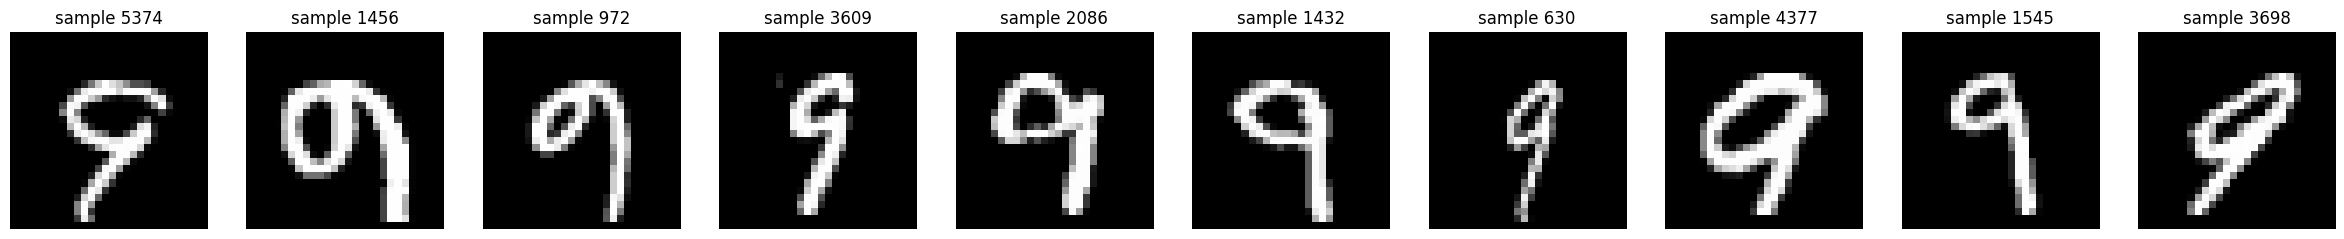

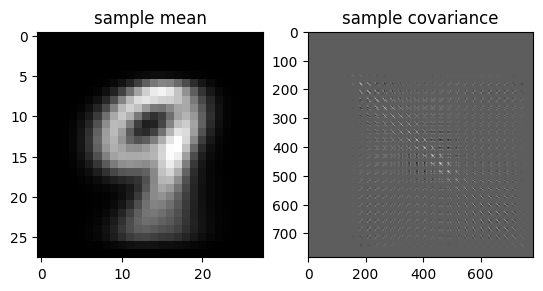

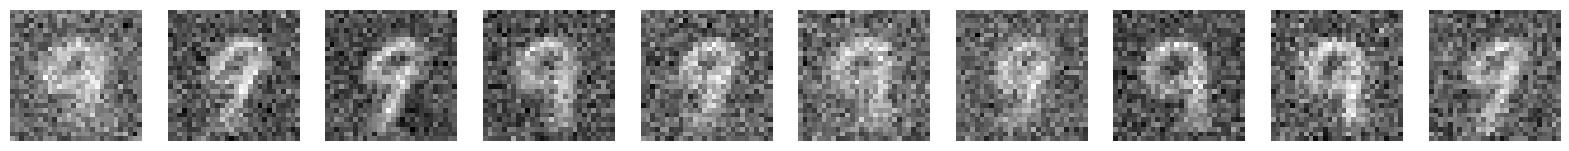

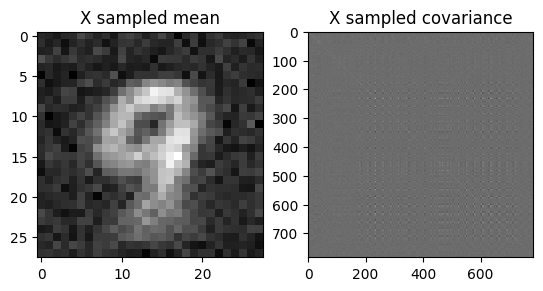

In [9]:
ppca([9], 1, 1)

Running PPCA model with 1 class: [9] and latent dimension 5


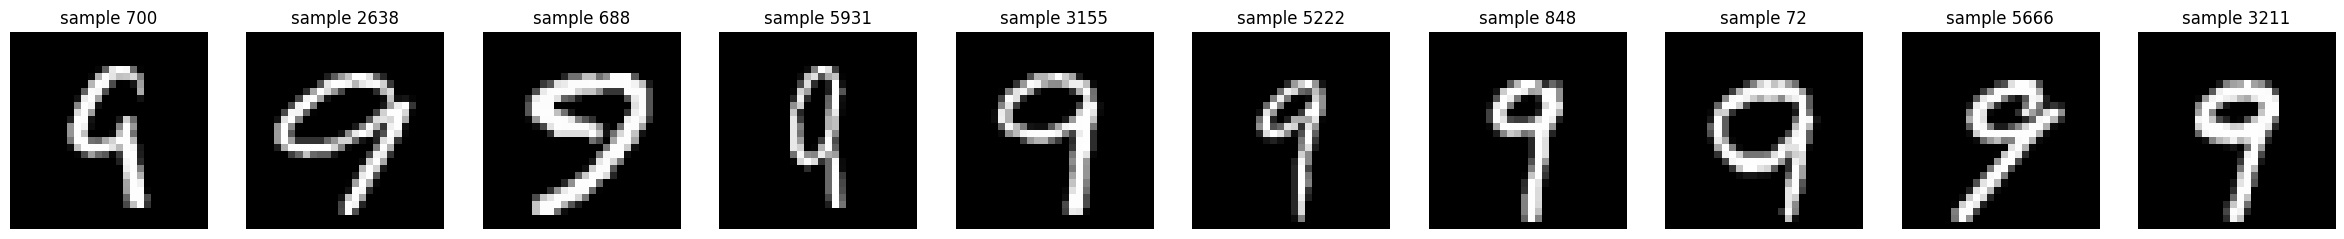

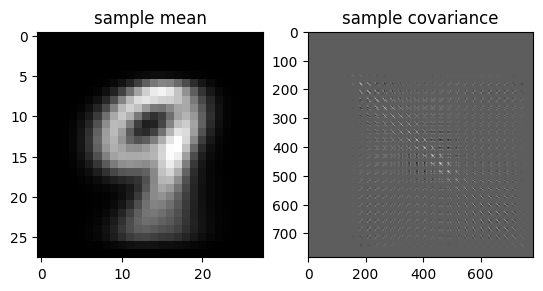

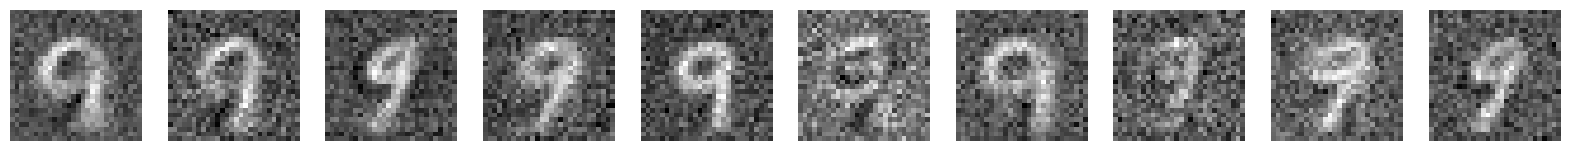

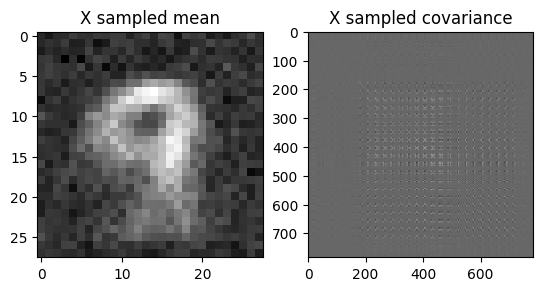

In [10]:
ppca([9], 5, 1)

Running PPCA model with 1 class: [9] and latent dimension 10


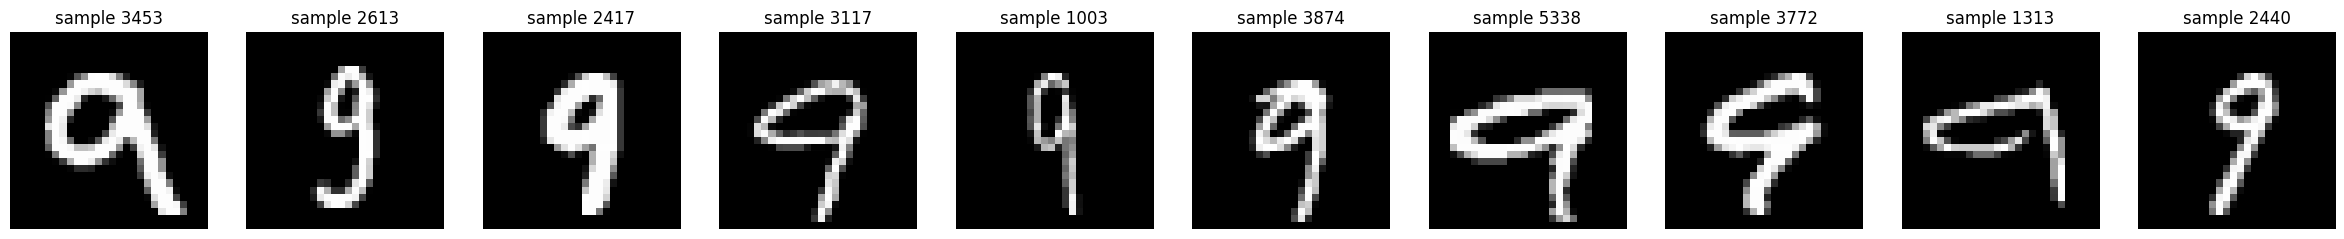

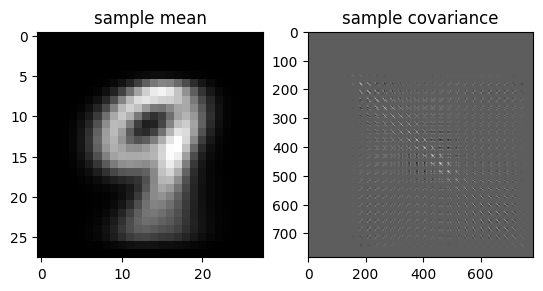

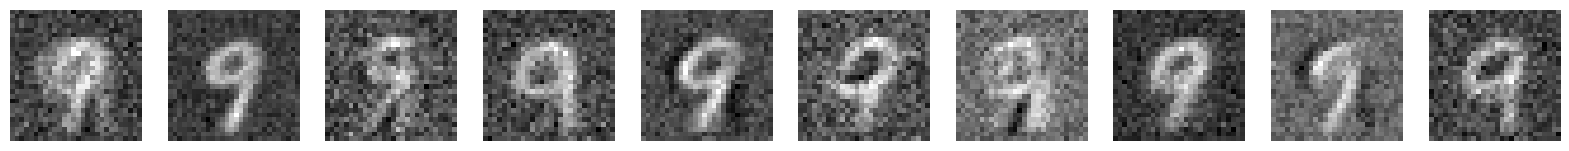

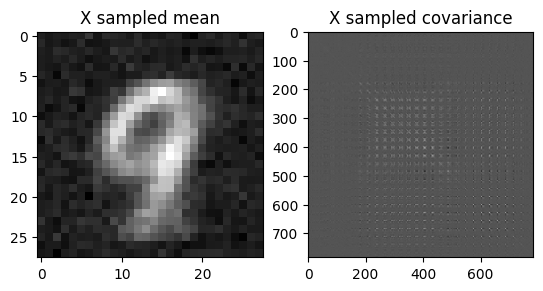

In [11]:
ppca([9], 10, 1)

Running PPCA model with 1 class: [9] and latent dimension 20


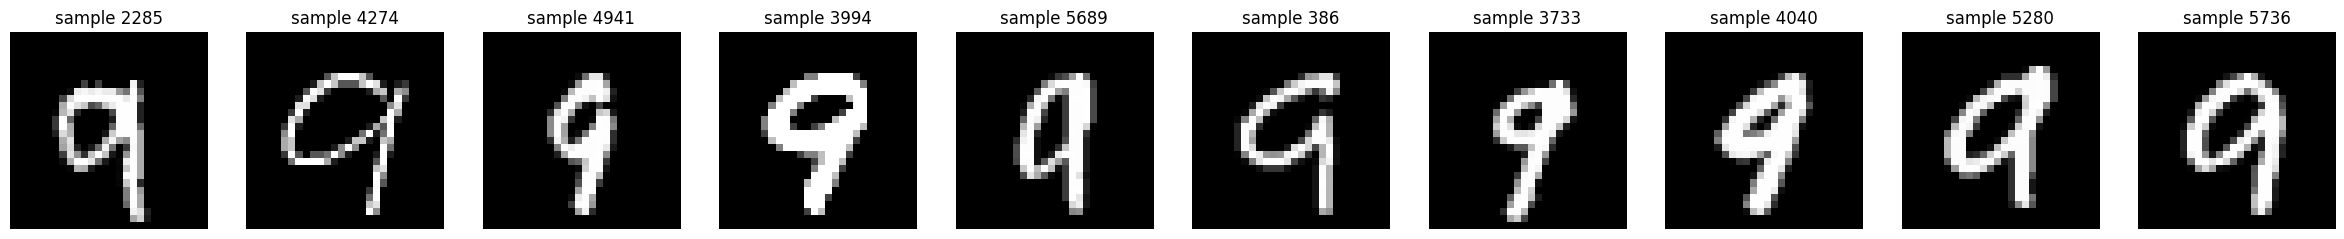

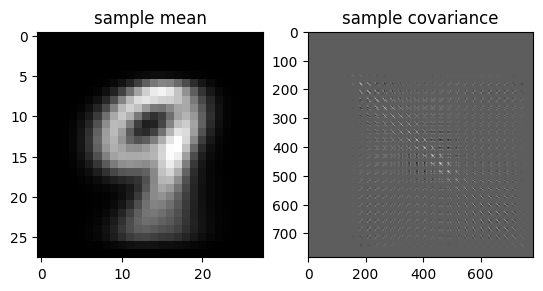

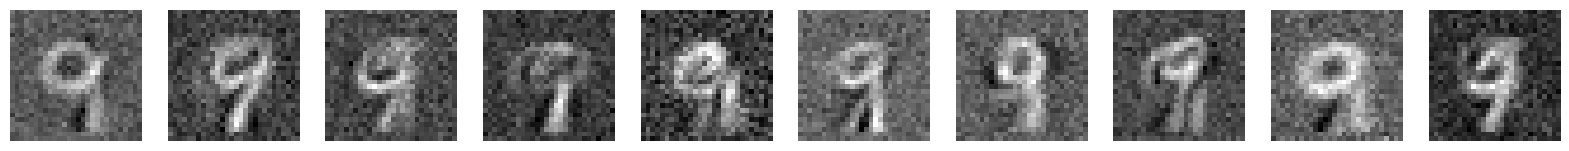

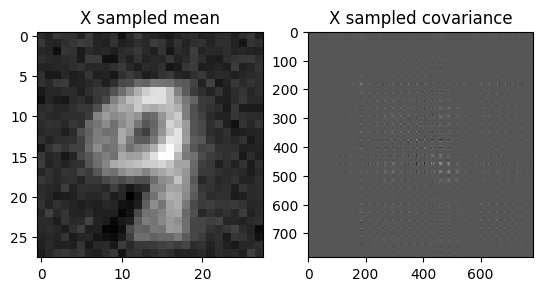

In [12]:
ppca([9], 20, 1)

Running PPCA model with 1 class: [9] and latent dimension 50


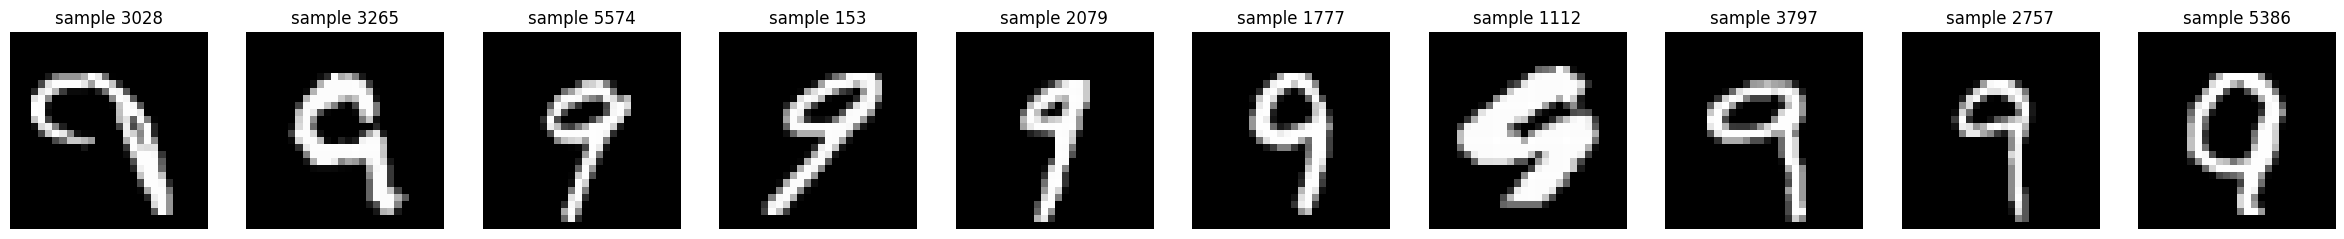

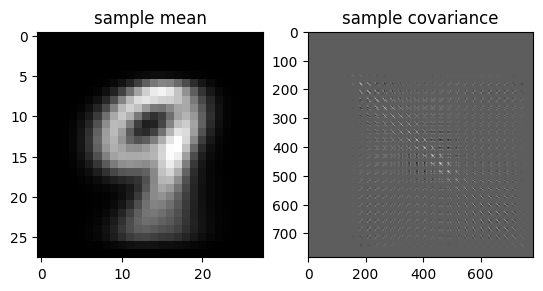

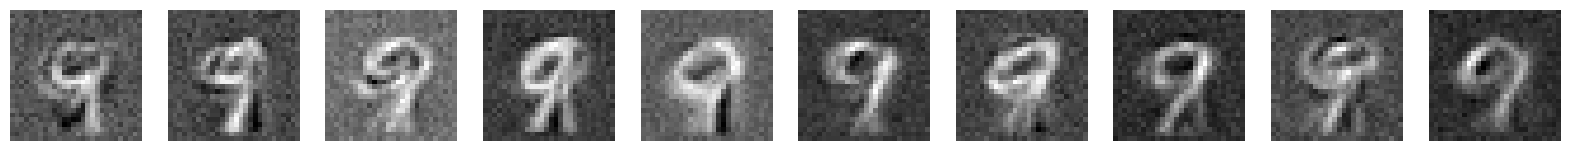

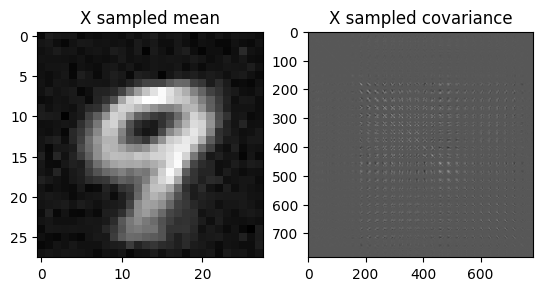

In [13]:
ppca([9], 50, 1)

Running PPCA model with 1 class: [9] and latent dimension 100


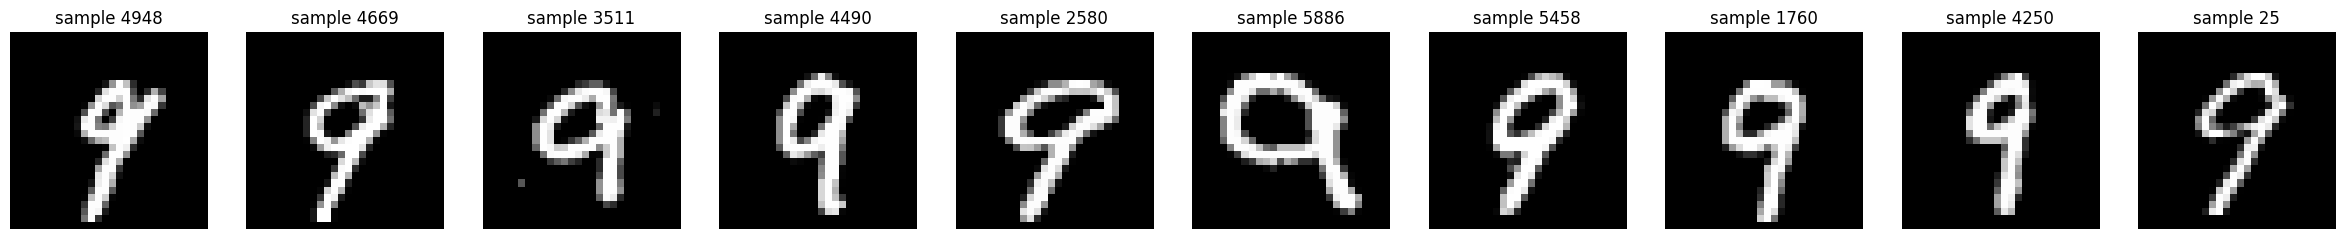

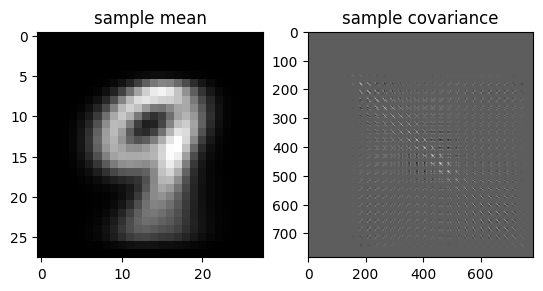

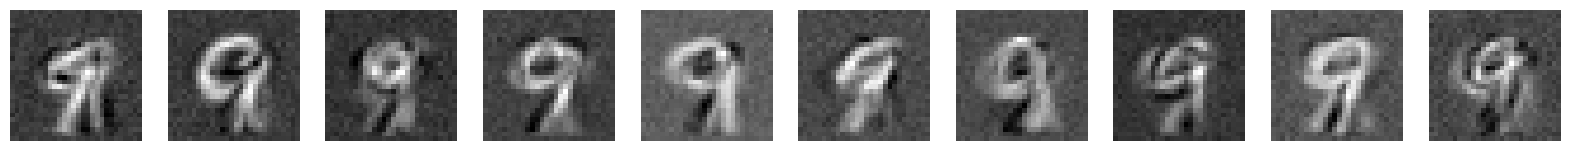

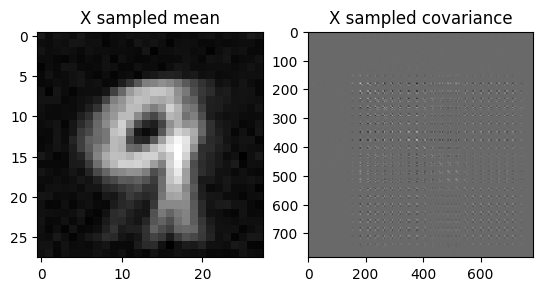

In [14]:
ppca([9], 100, 1)

Running PPCA model with 1 class: [9] and latent dimension 500


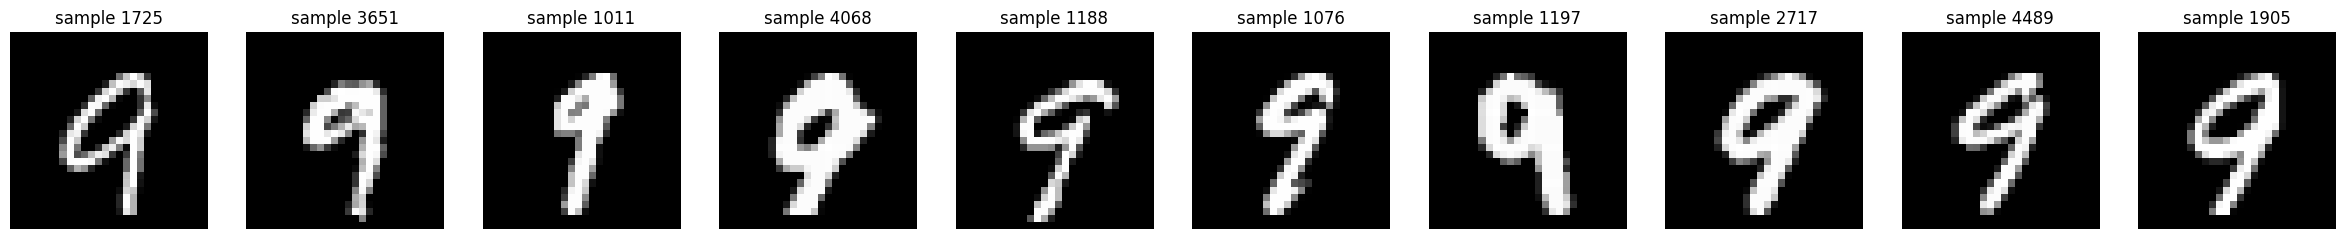

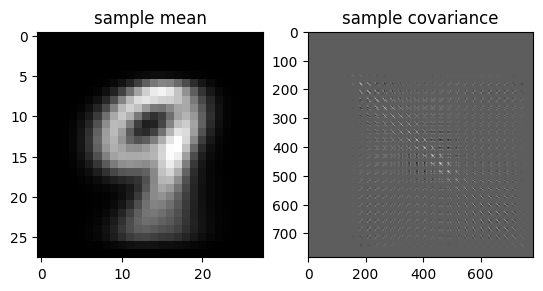

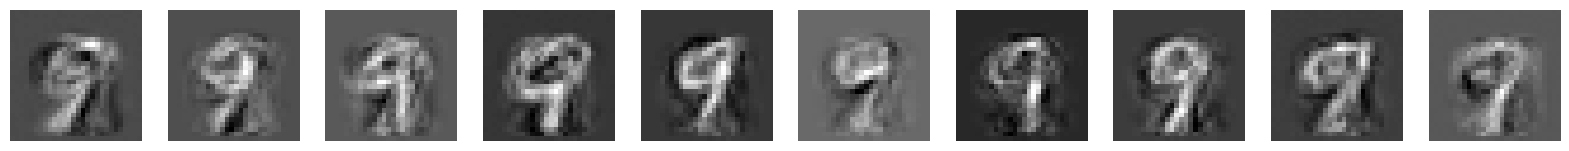

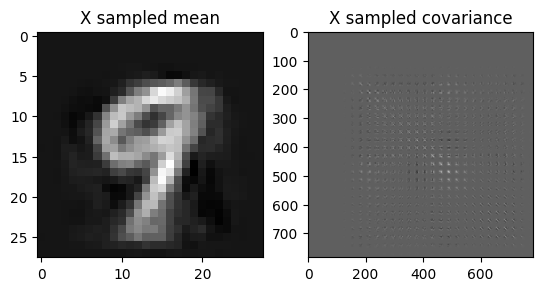

In [15]:
ppca([9], 500, 1)

The latent space defines how much information information is captured from the high dimensional data. When the latent space is too small, the model captures only the most dominant factors of variation in the data, which leads to underfittig of the data. When the latent space is too big, the model captures fine-grained details that may not generalize well, which leads to overfitting of the data. This is consistent with the observation, as demonstrated by the sampled images using different latent space dimensions. When d is too small, e.g. 1- 5, the model only captures the digit in the middle, leaving the rest of the images as random sample pixels. When d i between 20 -50, the model generates the best quality pictures. When d is too big, e.g. >= 100, the model captures too much unmeaningful variation so the sample images look unnatural.

## Part (e)
What happens if we increase the noise `eps`? Vary the variance of the epsilon and describe the quality of the image generation.

Running PPCA model with 1 class: [9] and latent dimension 10


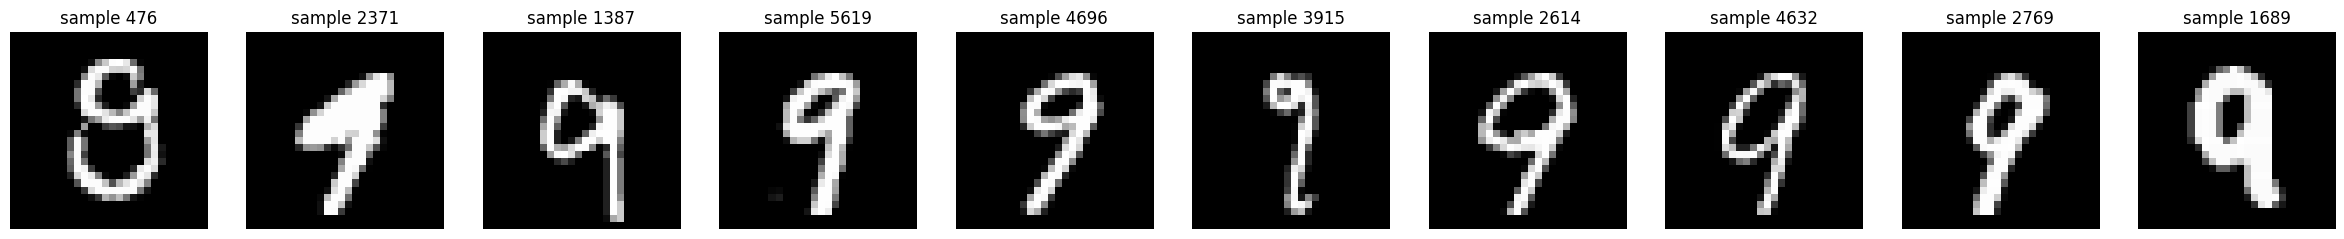

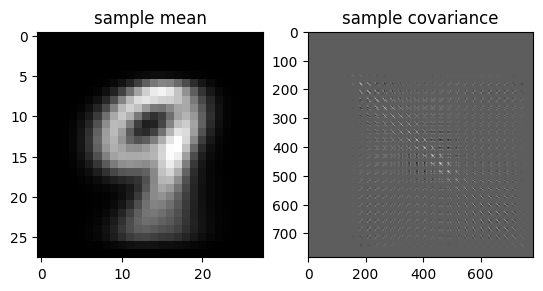

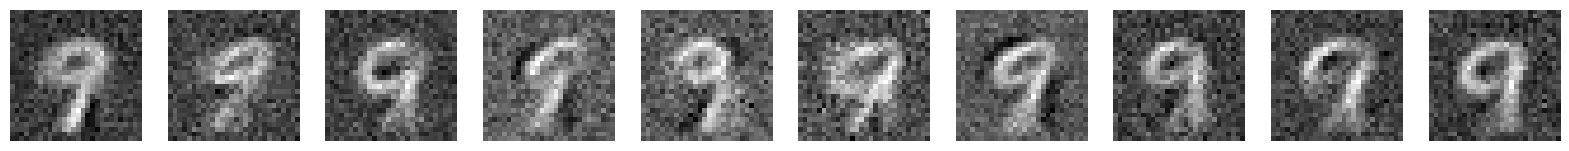

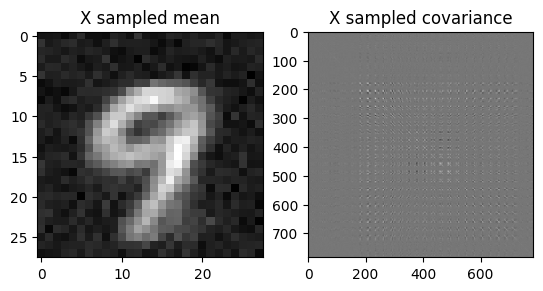

In [16]:
ppca([9], 10, 1)

Running PPCA model with 1 class: [9] and latent dimension 10


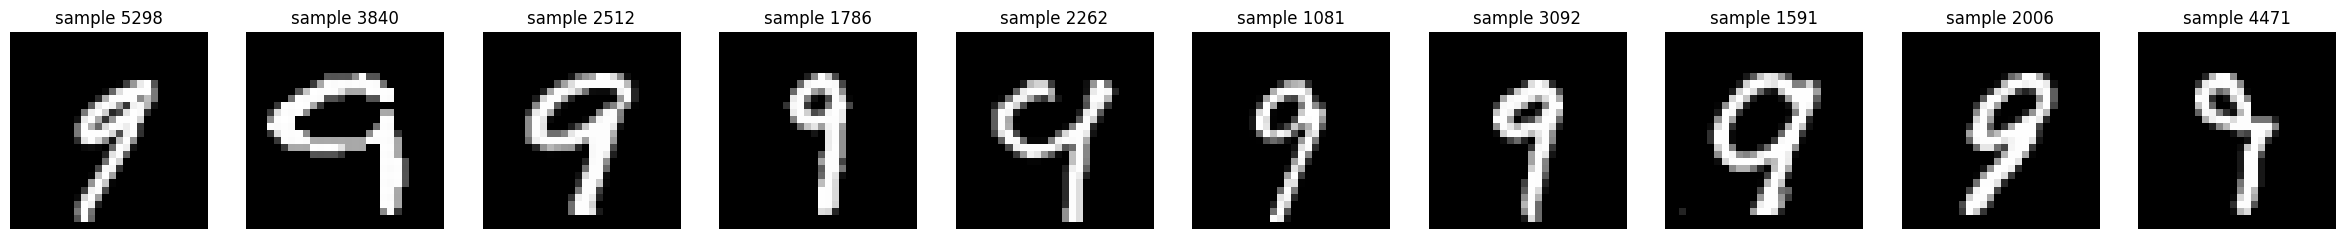

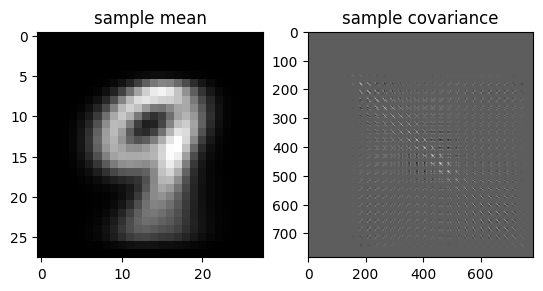

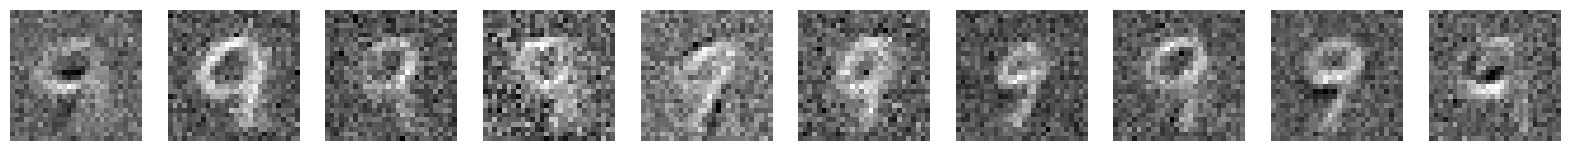

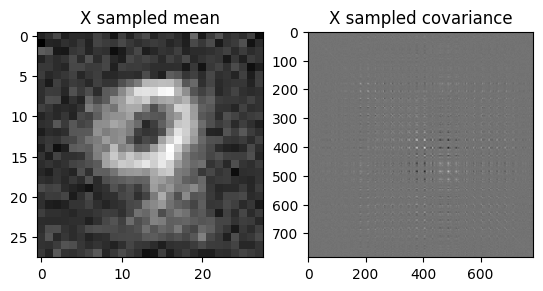

In [17]:
ppca([9], 10, 1.5)

Running PPCA model with 1 class: [9] and latent dimension 10


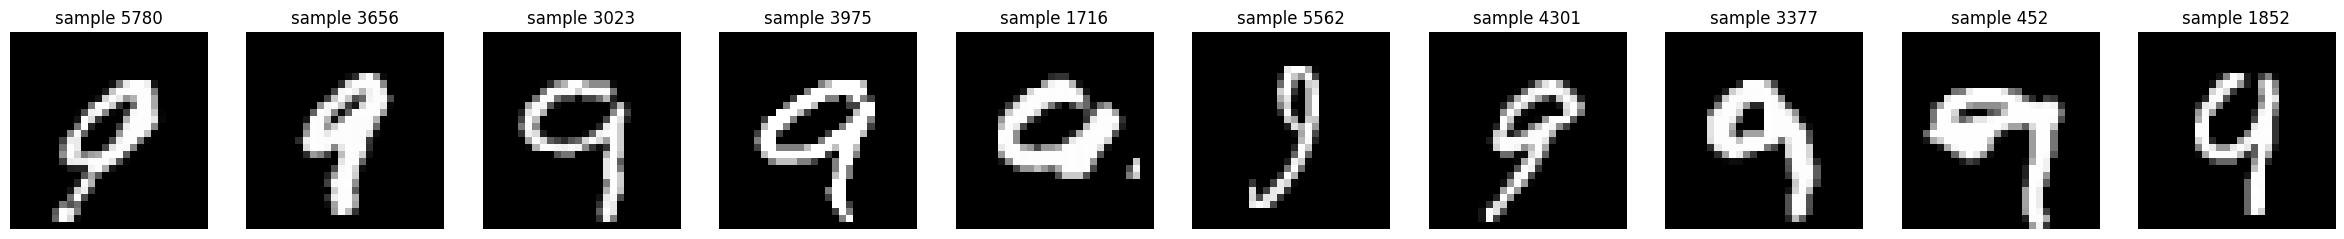

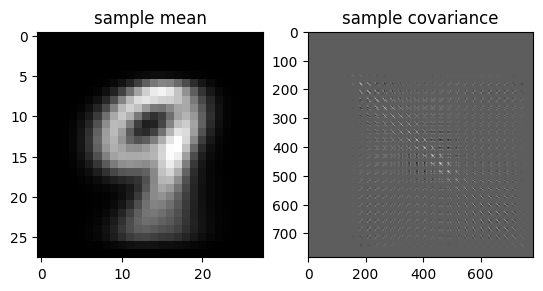

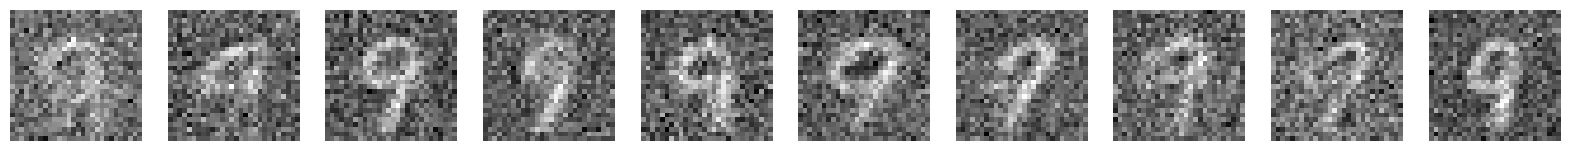

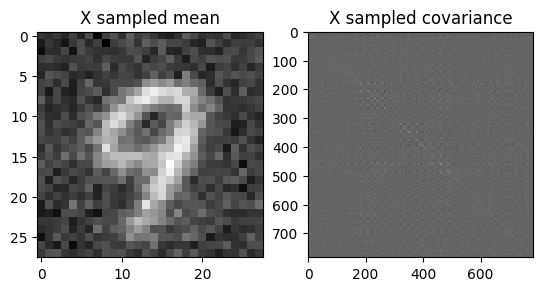

In [18]:
ppca([9], 10, 2)

Running PPCA model with 1 class: [9] and latent dimension 10


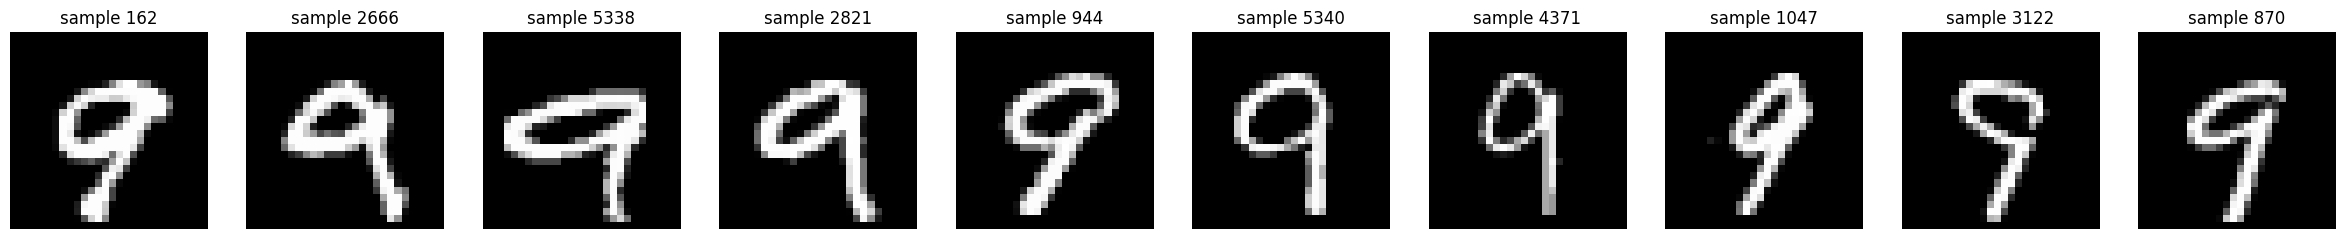

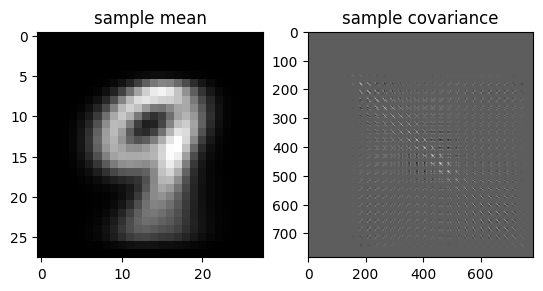

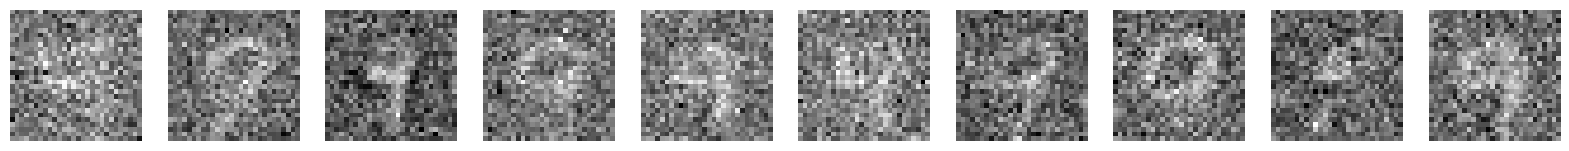

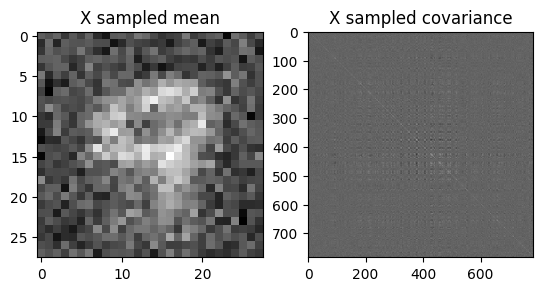

In [19]:
ppca([9], 10, 3)

Increasing eps will basically inject more noise into the model, so the generated samples have more variations, which can be checked by the sampled covariance matrix. Overall, increasing eps will decrease the quality of the image generation.

## Part (f)
Suppose now we move into a two/three-class regime for MNIST, by adding classes to the `CLASSES` list. What do you observe about the sample mean and covariance? Based on the data samples we have, do the images generated make sense? What assumptions should we modify so it can improve the quality of our generation, or perhaps handle even more classes?

Running PPCA model with 1 class: [9] and latent dimension 10


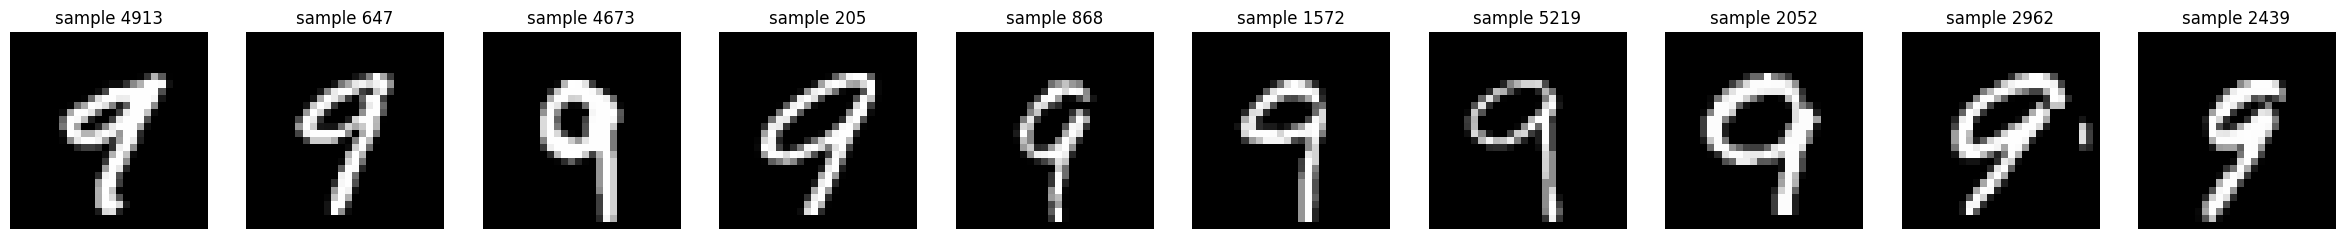

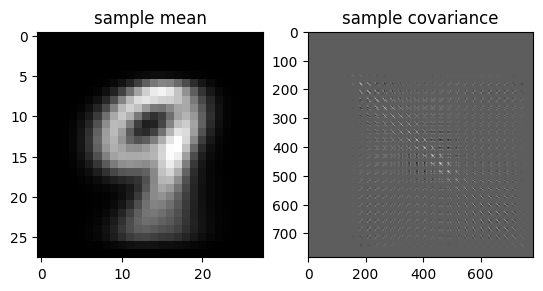

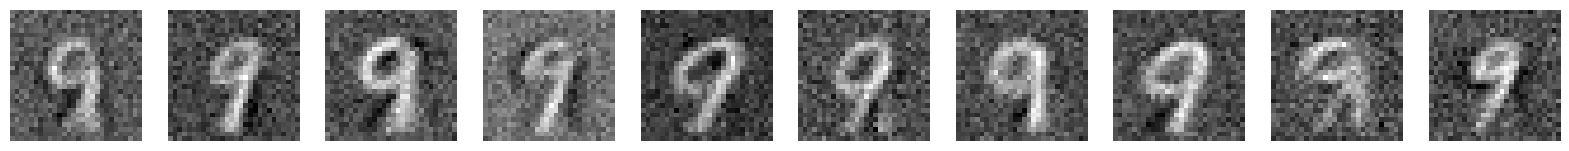

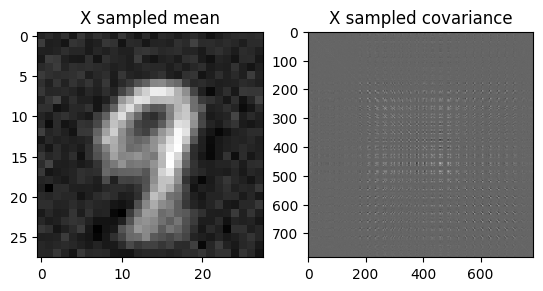

In [20]:
ppca([9], 10, 1)

Running PPCA model with 2 class: [2, 9] and latent dimension 10


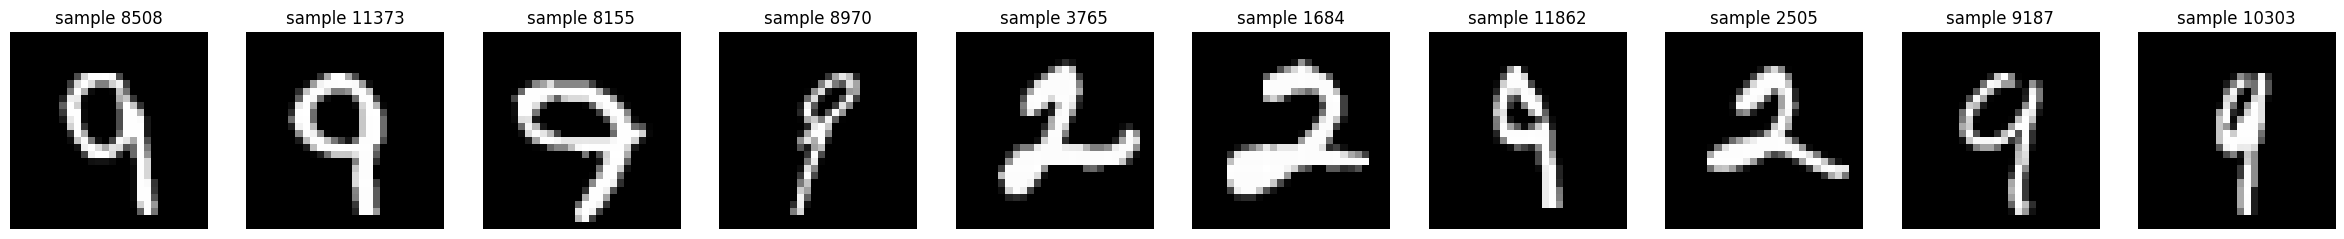

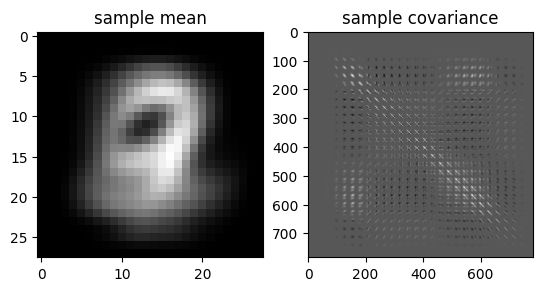

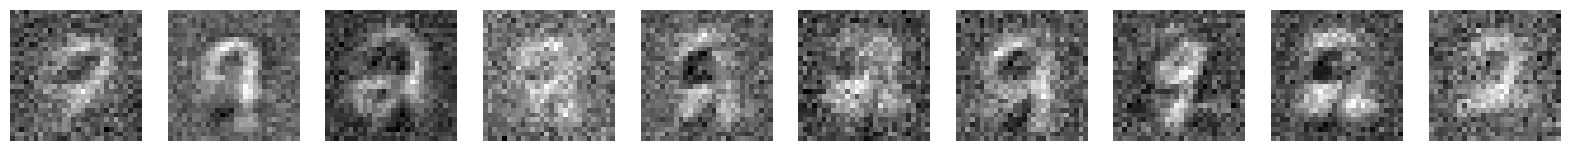

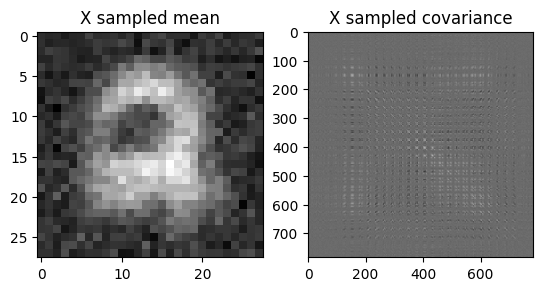

In [21]:
ppca([2, 9], 10, 1)

Running PPCA model with 3 class: [2, 5, 9] and latent dimension 10


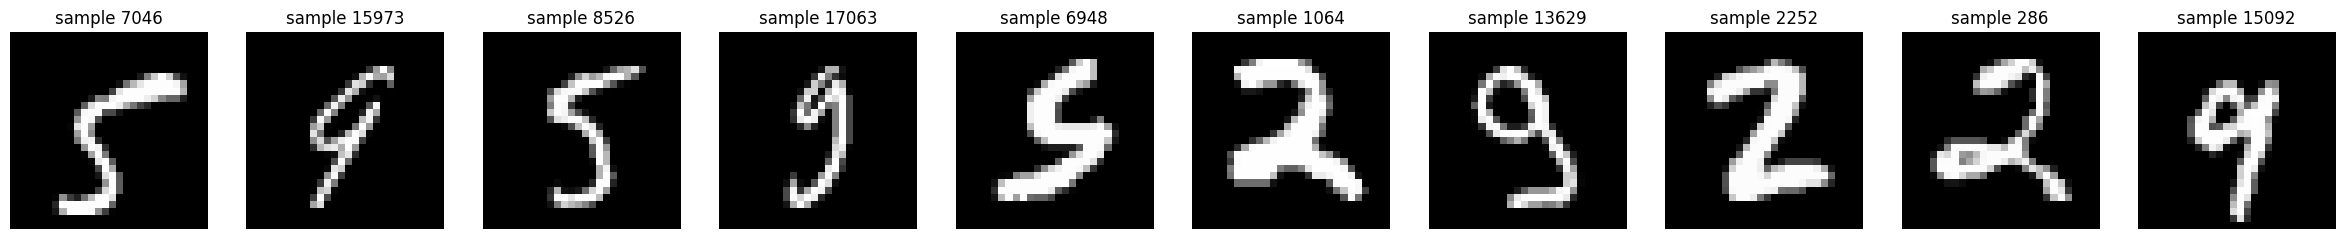

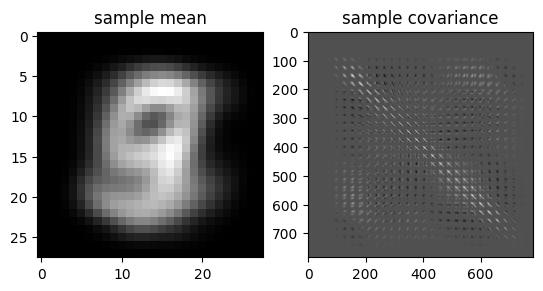

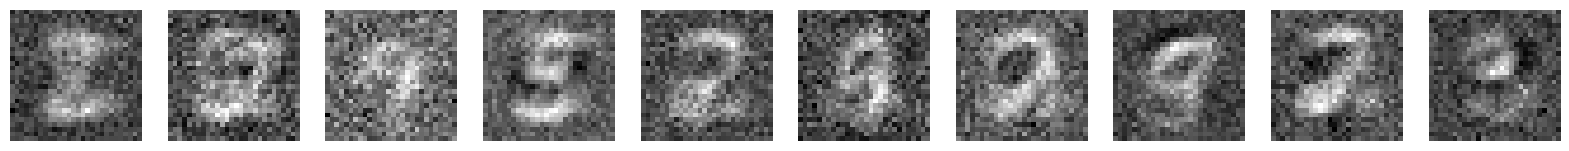

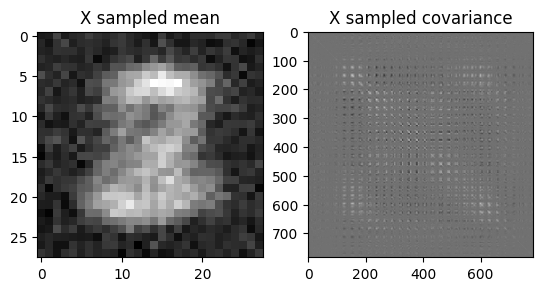

In [22]:
ppca([2, 5, 9], 10, 1)

The generated images does not make sense if we want it to adapt to two/three classes. This is because the sample mean will be an average from all these classes, which mostly likely does not even look like a legit digit, and the covariance matrix contains lot more variation. That is why we cannot get a good quality generated images. In our previous model, we assume one single latent space can capture the distribution of the generated class, so to capture the distribution of multiple classes, multiple latent space may needed, with each representing a different distribution associated with a class, and this is where Mixture of PPCA (MPPCA) model comes in to help.